<a href="https://colab.research.google.com/github/vincenzomanzoni/pytorch-forecasting-examples/blob/main/05_Pytorch_Forecasting_Example_Temporal_Fusion_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Forecasting | Temporal Fusion Transformer




## Install Pytorch Forecasting and import libraries

In [1]:
!pip install pytorch-forecasting optuna 1> /dev/null 2> /dev/null

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
from optuna.visualization import plot_param_importances

import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, QuantileLoss

## Dataset generation

In [3]:
data = generate_ar_data(seasonality=12, timesteps=364, n_series=1, seed=42, trend = 3.0, noise = 0.2)

In [4]:
data.head()

,series,time_idx,value
0,0,0,0.000000
1,0,1,0.199311
2,0,2,0.538868
3,0,3,0.683969
4,0,4,0.681237


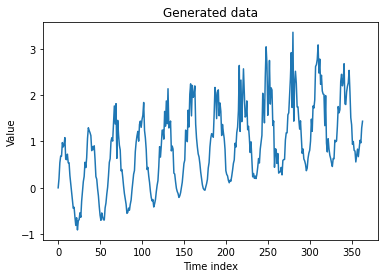

In [5]:
plt.plot(data.time_idx, data.value)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

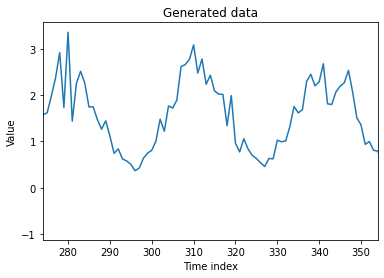

In [6]:
plt.plot(data.value)
plt.xlim(354-80, 354)
plt.title('Generated data')
plt.xlabel('Time index')
plt.ylabel('Value')
plt.show()

## Creation of datasets and dataloaders

In [7]:
# Create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 20
batch_size = 16

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],    
    time_varying_known_reals=["time_idx"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length
)
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Calculate Baseline Error

In [8]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.5114)

## Train Temporal Fusion Transformer (TFT)

In [21]:
pl.seed_everything(83)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[early_stop_callback]
)

import logging 
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

quantiles = [0.02, 0.25, 0.5, 0.75, 0.98]
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=len(quantiles),  # quantiles
    loss=QuantileLoss(quantiles=quantiles),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 15.9k


In [ ]:
trainer.fit(
  tft,
  train_dataloader=train_dataloader,
  val_dataloaders=val_dataloader,
)

In [23]:
best_model_path = trainer.checkpoint_callback.best_model_path  
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path) 

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
mae = (actuals - predictions).abs().mean().item()
mape = (100 * (actuals - predictions) / actuals).abs().mean().item()

print("MAE: {0}".format(mae))
print("MAPE: {0}".format(mape))

MAE: 0.14865881204605103
MAPE: 11.614919662475586


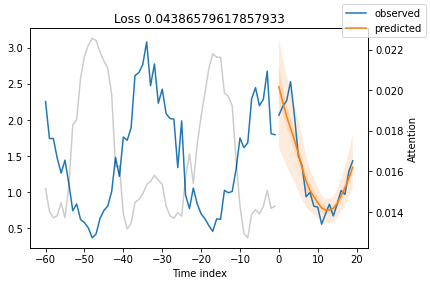

In [24]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)
best_model.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);